<a href="https://colab.research.google.com/github/mardycow/kaggle-titanic-decision-tree/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка данных

Для работы с этим ноутбуком нужны файлы `train.csv` и `test.csv` с соревнования Kaggle - https://www.kaggle.com/competitions/titanic .

При работе в Colab достаточно перетащить файлы `train.csv` и `test.csv` в папку `/content`.

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

## Импорт библиотек + обзор данных

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


<Axes: >

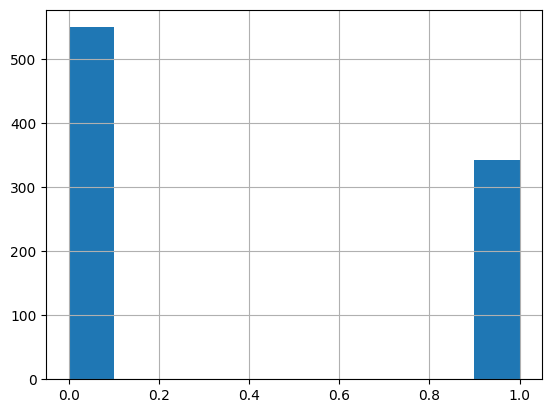

In [ ]:
train_df['Survived'].hist()

In [ ]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


## Удаление лишних столбцов

In [ ]:
train_df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

## Проверка дубликатов

In [ ]:
print(f"Count of complete duplicates: {train_df.duplicated(keep='last').sum()}")

Count of complete duplicates: 111


## Заполнение пропусков

In [ ]:
train_df['Embarked'].value_counts()

,count
Embarked,
S,644
C,168
Q,77


In [ ]:
train_df['Age'].describe()

,Age
count,714.000000
mean,29.699118
std,14.526497
min,0.420000
25%,20.125000
50%,28.000000
75%,38.000000
max,80.000000


In [ ]:
test_df['Fare'].describe()

,Fare
count,417.000000
mean,35.627188
std,55.907576
min,0.000000
25%,7.895800
50%,14.454200
75%,31.500000
max,512.329200


In [ ]:
def miss_values(df):
  miss_values = df.isna().sum()
  return miss_values[miss_values > 0]

In [ ]:
miss_values(train_df)

,0
Age,177
Embarked,2


In [ ]:
miss_values(test_df)

,0
Age,86
Fare,1


In [ ]:
train_df.groupby('Survived')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


In [ ]:
train_df.loc[:, 'Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df.loc[:, 'Age'] = test_df['Age'].fillna(test_df['Age'].median())

In [ ]:
train_df.loc[:, 'Embarked'] = train_df['Embarked'].fillna('S')

In [ ]:
test_df.loc[:, 'Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

## One-hot Encoding

In [ ]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S
889,0,3,female,28.0,1,2,23.4500,S


In [ ]:
train_df['is_train'] = 1
test_df['is_train'] = 0

combined_df = pd.concat([train_df, test_df], sort=False)
combined_df = pd.get_dummies(combined_df, columns=['Embarked'], prefix='Embarked')

In [ ]:
combined_df['Sex'] = pd.factorize(combined_df['Sex'])[0]

In [ ]:
train_df = combined_df[combined_df['is_train'] == 1].drop(columns=['is_train'])
test_df = combined_df[combined_df['is_train'] == 0].drop(columns=['is_train'])

train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0.0,3,0,22.0,1,0,7.2500,False,False,True
2,1.0,1,1,38.0,1,0,71.2833,True,False,False
3,1.0,3,1,26.0,0,0,7.9250,False,False,True
4,1.0,1,1,35.0,1,0,53.1000,False,False,True
5,0.0,3,0,35.0,0,0,8.0500,False,False,True
...,...,...,...,...,...,...,...,...,...,...
887,0.0,2,0,27.0,0,0,13.0000,False,False,True
888,1.0,1,1,19.0,0,0,30.0000,False,False,True
889,0.0,3,1,28.0,1,2,23.4500,False,False,True


## Разбиение test_train

In [ ]:
y = train_df['Survived']
X = train_df.drop('Survived', axis=1).copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

## Построение модели

### Дерево решений

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dectree = DecisionTreeClassifier(max_depth=4, random_state=21)
dectree.fit(X_train,y_train)
dectree.score(X_test,y_test)

0.8071748878923767

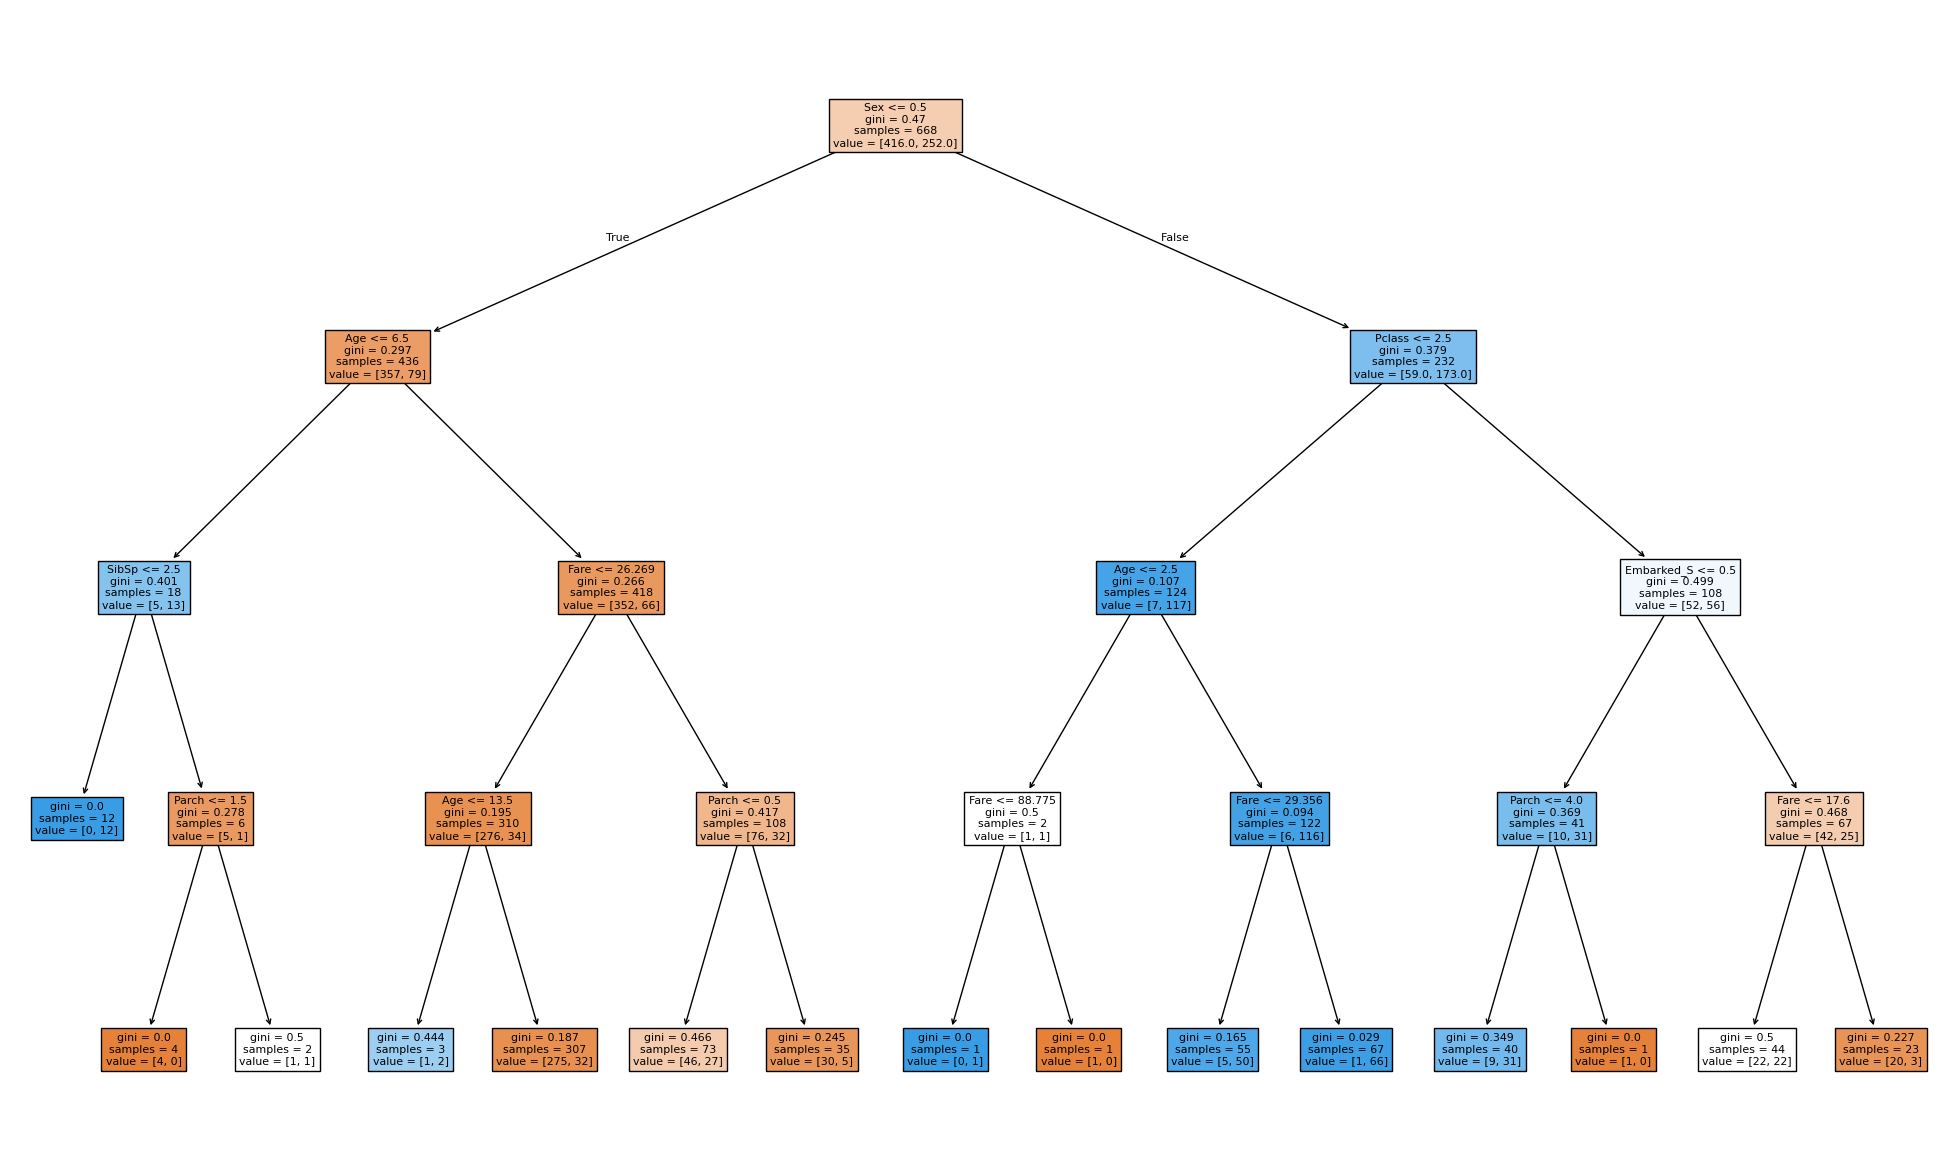

In [ ]:
plt.figure(figsize=((25,15)))
plot_tree(dectree,
          filled=True,
          feature_names=X.columns)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = dectree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.8071748878923767
F1-score: 0.7999073412659947


### Случайный лес

In [ ]:
rfc = RandomForestClassifier(n_estimators = 30,  max_depth=5,  random_state=21)
rfc.fit(X_train, y_train)
rfc.score (X_test, y_test)

0.8116591928251121

In [ ]:
y_pred=rfc.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,123,10
1,32,58


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred)

0.7341772151898734

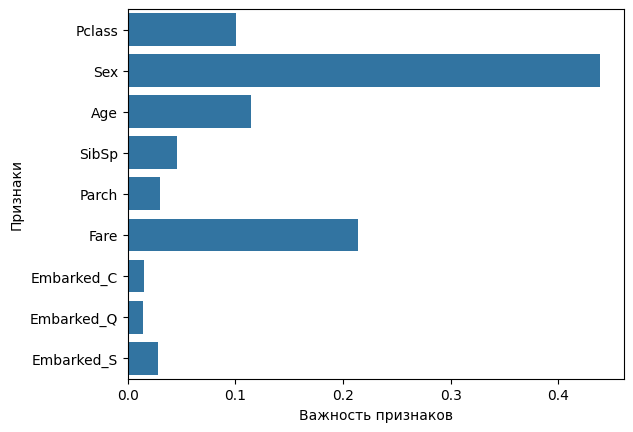

In [ ]:
sns.barplot(x=rfc.feature_importances_, y=X_test.columns)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.show()